In [11]:
from google.colab import files
uploaded = files.upload()
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import math


Saving training_df.tsv to training_df.tsv


# PRI THE DATABASER

In [12]:
df = pd.read_csv("training_df.tsv", sep = "\t")
print(df.tail())

     UniProt_ID  Class  Label  \
8016     P82916      0      5   
8017     P34164      0      5   
8018     Q9FN69      0      5   
8019     Q16617      0      5   
8020     Q6DYE4      0      5   

                                                Frag_90 SP_15  
8016  MSVVRSSVHAKWIVGKVIGTAMQKTAKVRVTRLVLDPYLLKYFNKR...   NIL  
8017  MGTTTSHPAQKKQTTKKCRAPIMSDVREKPSNAQGCEPQEMDAVSK...   NIL  
8018  MATGQNRTTVPENLKKHLAVSVRNIQWSYGIFWSVSASQSGVLEWG...   NIL  
8019  MELCRSLALLGGSLGLMFCLIALSTDFWFEAVGPTHSAHSGLWPTG...   NIL  
8020  MVSLVNSSLTCSSLTLNLLPILRTETPSLSRKRRAAYVAATSSRDV...   NIL  


In [13]:
fold_1_smaller = df[df['Class'] == 1]
fold_smaller = fold_1_smaller[fold_1_smaller['Label'] == 1]
fold_smaller = pd.concat([fold_smaller, fold_1_smaller[fold_1_smaller['Label'] == 2]])
fold_smaller = pd.concat([fold_smaller, fold_1_smaller[fold_1_smaller['Label'] == 3]])
fold_seq = fold_smaller['SP_15']

# KIAN'S PART FOR THE MATRIX

In [14]:
swissprot = np.array([0.0825, 0.0393, 0.0964, 0.0665,0.0552, 0.0671, 0.0579, 0.0536, 0.0406, 0.0707, 0.0410, 0.0100,
                      0.0546, 0.0227, 0.0386, 0.0292, 0.0138, 0.0590, 0.0474, 0.0685])

def compute_matrix(frag_15:pd.Series,output_arrayname:str) -> np.ndarray:
  '''Compute the position-specific weight matrix (PSWM) from a given FASTA file and save it as a .npz file.'''
  swissprot = np.array([0.0825, 0.0393, 0.0964, 0.0665,0.0552, 0.0671, 0.0579, 0.0536, 0.0406, 0.0707, 0.0410, 0.0100,
                      0.0546, 0.0227, 0.0386, 0.0292, 0.0138, 0.0590, 0.0474, 0.0685])
  alphabet = "AQLSREKTNGMWDHFYCIPV"
  pswm = np.ones((len(alphabet),len(frag_15[0])))
  seq_number = 0
  for frag in frag_15:
      seq_number += 1
      frag_m = np.zeros((len(alphabet),len(frag)))
      col = 0
      for res in frag:
        if res != "X":
          index = alphabet.index(res)
          frag_m[index][col] += 1
          col += 1
      pswm += frag_m
  pswm = (pswm/(seq_number+20))
  pswm = pswm / swissprot.reshape(-1, 1)
  pswm = np.log2(pswm)
  np.savez(output_arrayname, pswm)
  return pswm
pwsm = compute_matrix(fold_seq,"toy_pswm")

# BIANCA'S CODE FOR THE SCORES

In [15]:
def compute_score (sequence,  window, pswm, alphabet = "AQLSREKTNGMWDHFYCIPV"):
  seq_scores = np.array([])
  for i in range(len(sequence)-(window)+1):
      score = 0
      l = sequence[i:i+window]
      for j in range(window):
          score = score + pswm[alphabet.find(l[j])][j]
      seq_scores = np.append(seq_scores, score)
  return seq_scores.max()

In [16]:
sequences = df[df['Label'] == 4]
sequences = sequences['Frag_90']
scores = np.array([])
for seq in sequences:
  score = compute_score(seq, 15, pwsm)
  #print(score)
  scores = np.append(scores, score)
print((len(scores)))


1604


# KIAN'S CODE FOR THRESHOLD

8.65721442477617
2.3186873403967376


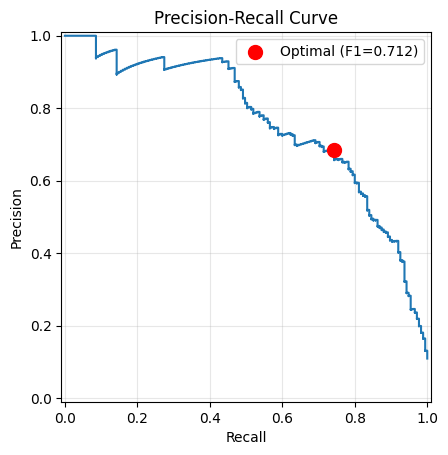

Optimal F1-score: 0.7123
Precision at optimal: 0.6842
Recall at optimal: 0.7429


In [17]:
# find the optimal threshold for classification
classes = df[df['Label'] == 4]
classes = classes['Class']
scores
precision, recall, thresholds = precision_recall_curve(classes, scores)

fscore = (2 * precision * recall) / (precision + recall + 1e-15)

index = np.argmax(fscore)
optimal_threshold = thresholds[index]
print(optimal_threshold)
print(scores.mean())
#y_test_scores = [1.2, -6, 3.33, 4, -2, 10, -1, 7.3, -3.1, -4.4, 5.5, 6.6, -5.2, -7.3, 2.2, 0.1, -1.5, 8.8, 4.4, -3.3, -6.6]
#y_pred_test = [int(t_score >= optimal_threshold) for t_score in y_test_scores]

#print(y_pred_test)


display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

# Add optimal point to the plot
optimal_precision = precision[index]
optimal_recall = recall[index]
optimal_fscore = fscore[index]

plt.scatter(optimal_recall, optimal_precision, color='red', s=100,
           label=f'Optimal (F1={optimal_fscore:.3f})', zorder=5)
plt.legend()
plt.title("Precision-Recall Curve")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal F1-score: {optimal_fscore:.4f}")
print(f"Precision at optimal: {optimal_precision:.4f}")
print(f"Recall at optimal: {optimal_recall:.4f}")

In [18]:
labels = np.array([])
data = df[df['Label'] == 5]
classes = data['Class']
print(classes.head(3))
for el in classes:
  #print(el)
  labels = np.append(labels, el)
#print(labels)
#print(predictions)
predictions = np.array([])
sequences = data['Frag_90']
scores = np.array([])
for seq in sequences:
  score = compute_score(seq, 15, pwsm)
  scores = np.append(scores, score)
print(scores)
for score in scores:
  if score >= optimal_threshold:
    predictions = np.append(predictions, 1)
  else:
    predictions = np.append(predictions, 0)
print(predictions)
print(len(sequences), len(scores),len(predictions))

700    1
701    1
702    1
Name: Class, dtype: int64
[12.44791651 17.89175132 12.30054028 ...  4.20435104  8.53004665
  2.92610469]
[1. 1. 1. ... 0. 0. 0.]
1603 1603 1603


# AMIR'S CODE FOR METRICS

In [19]:
def confusion_matrix(preds, labels):
  TP, TN, FP, FN = 0,0,0,0
  for i in range(len(preds)):
    if preds[i] == labels[i] and labels[i] == 0:
      TN += 1
    elif preds[i] == labels[i] and labels[i] == 1:
      TP += 1
    elif preds[i] != labels[i] and labels[i] == 0:
      FP += 1
    elif preds[i] != labels[i] and labels[i] == 1:
      FN +=1
  return TN, FP, FN, TP
print(confusion_matrix(predictions, labels))

(1368, 61, 36, 138)


In [20]:
def accuracy(TN, FP, FN, TP):
    return (TP + TN) / (TP + TN + FP + FN)
TN, FP, FN, TP = confusion_matrix(predictions, labels)
print(accuracy(TN, FP, FN, TP))

0.9394884591391142


In [21]:
def mcc(TN, FP, FN, TP):
    numerator = (TP * TN) - (FP * FN)
    denominator = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return numerator / denominator if denominator != 0 else 0.0
print(mcc(TN, FP, FN, TP))

0.7079178758478392


In [22]:
def recall(TN, FP, FN, TP):
    return TP / (TP + FN) if (TP + FN) != 0 else 0.0
print(recall(TN, FP, FN, TP))
rec = recall(TN, FP, FN, TP)

0.7931034482758621


In [23]:
def precision(TN, FP, FN, TP):
    return TP / (TP + FP) if (TP + FP) != 0 else 0.0
print(precision(TN, FP, FN, TP))
prec = precision(TN, FP, FN, TP)

0.6934673366834171


In [24]:
def f1_score(prec, rec):
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0.0
print(f1_score(prec, rec))

0.739946380697051


# BIANCA'S CROSS-VALIDATION CYCLE

In [26]:

def cross_val(cycle_number:int):
  validation = []
  testing = []
  training = []
  for j in range(cycle_number):
    validation.append(j+1)
    testing.append(((j+1)%cycle_number)+1)
    training_j = []
    for i in range(cycle_number):
      if i != j and i != (j+1)%cycle_number:
        training_j.append(i+1)
    training.append(training_j)
    print("ROUND "+str(j+1))
    print("validation:", validation[j])
    print("testing:", testing[j])
    print("training:", training[j])
    print("")
    j +=1
  print("")
  print(training)
  print(validation)
  print(testing)
  return training, validation, testing
cross_val(5)


ROUND 1
validation: 1
testing: 2
training: [3, 4, 5]

ROUND 2
validation: 2
testing: 3
training: [1, 4, 5]

ROUND 3
validation: 3
testing: 4
training: [1, 2, 5]

ROUND 4
validation: 4
testing: 5
training: [1, 2, 3]

ROUND 5
validation: 5
testing: 1
training: [2, 3, 4]


[[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 1]


([[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]],
 [1, 2, 3, 4, 5],
 [2, 3, 4, 5, 1])

TRAINING (Cross-Validation)

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, confusion_matrix

# --- CROSS-VALIDATION SETUP ---
cycles = 5
training, validation, testing = cross_val(cycles)

# --- INITIALIZE METRICS ---
confusions = [[] for _ in range(cycles)]
accuracies = np.array([])
precisions = np.array([])
recalls = np.array([])
f1s = np.array([])
mccs = np.array([])
ths = np.array([])

# --- CROSS-VALIDATION LOOP ---
for i in range(cycles):
    print(f"\n{'='*30}\nROUND {i+1}\n{'='*30}")

    # -------------------- TRAINING --------------------
    sp_15 = pd.Series([], dtype=object)
    for el in training[i]:
        df_pswm = df[df['Class'] == 1]
        df_pswm = df_pswm[df_pswm['Label'] == el]
        sp_15 = pd.concat([sp_15, df_pswm['SP_15']])

    sp_15 = sp_15.reset_index(drop=True)  # ensure sequential index

    print(f"Training Set Round {i+1}")
    print(sp_15.head(2))
    print(sp_15.tail(2))
    print("")

    pswm = compute_matrix(sp_15, f'pswm_{i+1}')
    print(f"pswm_{i+1}")
    print(pswm)
    print("")

    # -------------------- VALIDATION --------------------
    sequences_val = df[df['Label'] == validation[i]]['Frag_90']
    validation_classes = df[df['Label'] == validation[i]]['Class']

    print(f"Validation Set Round {i+1}")
    print(sequences_val.head(2))
    print(sequences_val.tail(2))

    validation_scores = np.array([])
    for seq in sequences_val:
        score = compute_score(seq, 15, pswm)
        validation_scores = np.append(validation_scores, score)

    print(f"Validation sequences processed: {len(validation_scores)}\n")

    # -------------------- THRESHOLD SELECTION --------------------
    precision_vals, recall_vals, thresholds = precision_recall_curve(validation_classes, validation_scores)
    fscore = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-15)
    index = np.argmax(fscore)
    optimal_threshold = thresholds[index]

    print(f"Optimal threshold for round {i+1}: {optimal_threshold}\n")

    # -------------------- TESTING --------------------
    testing_sequences = df[df['Label'] == testing[i]]['Frag_90']
    testing_classes = df[df['Label'] == testing[i]]['Class']

    testing_scores = np.array([compute_score(seq, 15, pswm) for seq in testing_sequences])

    predictions = np.where(testing_scores >= optimal_threshold, 1, 0)

    print(f"Testing Set Round {i+1}")
    print(testing_sequences.head(2))
    print(testing_sequences.tail(2))
    print(f"Testing samples: {len(testing_sequences)}\n")

    # -------------------- METRICS --------------------
    cm = confusion_matrix(testing_classes, predictions).ravel()
    TN, FP, FN, TP = cm if len(cm) == 4 else (0, 0, 0, 0)

    # Assuming you already have accuracy(), recall(), precision(), f1_score(), mcc() defined
    acc = accuracy(TN, FP, FN, TP)
    rec = recall(TN, FP, FN, TP)
    prec = precision(TN, FP, FN, TP)
    f1 = f1_score(prec, rec)
    MCC = mcc(TN, FP, FN, TP)

    # Store metrics
    confusions[i].append((TN, FP, FN, TP))
    accuracies = np.append(accuracies, acc)
    recalls = np.append(recalls, rec)
    precisions = np.append(precisions, prec)
    f1s = np.append(f1s, f1)
    mccs = np.append(mccs, MCC)
    ths = np.append(ths, optimal_threshold)

    avg_acc = np.mean(accuracies)
    avg_rec = np.mean(recalls)
    avg_prec = np.mean(precisions)
    avg_f1 = np.mean(f1s)
    avg_mcc = np.mean(mccs)

    std_acc = np.std(accuracies)
    std_rec = np.std(recalls)
    std_prec = np.std(precisions)
    std_f1 = np.std(f1s)

    runs_df = pd.DataFrame({
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-score': f1s,
        'MCC': mccs,
        'Threshold': ths
    })



    summary_df = pd.DataFrame({
      "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "MCC"],
      "Average": [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1s),
        np.mean(mccs)
      ],
      "Std": [
        np.std(accuracies),
        np.std(precisions),
        np.std(recalls),
        np.std(f1s),
        np.std(mccs)
      ]
    })

runs_df.to_csv("runs_report.csv", index=True)
summary_df.to_csv("metrics_report.csv", index=True)


# --- SUMMARY ---
print("\n===== CROSS-VALIDATION SUMMARY =====")
print(f"Accuracies: {accuracies}")
print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")
print(f"F1-scores: {f1s}")
print(f"MCCs: {mccs}")
print(f"Thresholds: {ths}")
print(f"Confusion matrices: {confusions}")

print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average Precision: {avg_prec:.4f}")
print(f"Average Recall: {avg_rec:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average MCC: {avg_mcc:.4f}")

print(f"Standard Deviation Accuracy: {std_acc:.4f}")
print(f"Standard Deviation Precision: {std_prec:.4f}")
print(f"Standard Deviation Recall: {std_rec:.4f}")
print(f"Standard Deviation F1-score: {std_f1:.4f}")

print(runs_df)
print(summary_df)



ROUND 1
validation: 1
testing: 2
training: [3, 4, 5]

ROUND 2
validation: 2
testing: 3
training: [1, 4, 5]

ROUND 3
validation: 3
testing: 4
training: [1, 2, 5]

ROUND 4
validation: 4
testing: 5
training: [1, 2, 3]

ROUND 5
validation: 5
testing: 1
training: [2, 3, 4]


[[3, 4, 5], [1, 4, 5], [1, 2, 5], [1, 2, 3], [2, 3, 4]]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 1]

ROUND 1
Training Set Round 1
0    SVILISRISSVGGEA
1    LLLGLLGPAACWALG
dtype: object
522    LLQLSQLLAVTQGKT
523    WFAIATLITICYAAK
dtype: object

pswm_1
[[ 0.18442457  0.51199923  0.21243895  0.15585542  1.18442457  0.97143085
   0.59946207  0.93826398  0.95494273  0.09696173  1.83392732  0.26688673
   2.51762378  1.12670907 -0.78756105]
 [-3.41813596 -3.41813596 -2.09620787 -2.41813596 -1.61078104 -0.83317346
  -0.83317346 -2.41813596  0.33675154 -0.33067312 -2.83317346  0.82979155
  -1.61078104  0.82979155  0.58186404]
 [ 2.0882601   2.11390869  1.9668403   2.06214726  1.90207005  1.70521272
   1.72198843  1.08177607 -0.58335678  